

![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/healthcare/CLINICAL_NER.ipynb)




# **How to use Licensed NER models in Spark NLP**

### Spark NLP documentation and instructions:
https://nlp.johnsnowlabs.com/docs/en/quickstart

### You can find details about Spark NLP annotators here:
https://nlp.johnsnowlabs.com/docs/en/annotators

### You can find details about Spark NLP models here:
https://nlp.johnsnowlabs.com/models


To run this yourself, you will need to upload your license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

## 1. Colab Setup

Import license keys

In [ ]:
import os
import json

with open('/content/spark_nlp_for_healthcare.json', 'r') as f:
    license_keys = json.load(f)

license_keys.keys()

secret = license_keys['SECRET']
os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['AWS_ACCESS_KEY_ID'] = license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']
sparknlp_version = license_keys["PUBLIC_VERSION"]
jsl_version = license_keys["JSL_VERSION"]

print ('SparkNLP Version:', sparknlp_version)
print ('SparkNLP-JSL Version:', jsl_version)

SparkNLP Version: 2.6.0
SparkNLP-JSL Version: 2.6.0


Install dependencies

In [ ]:
# Install Java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==$sparknlp_version
! python -m pip install --upgrade spark-nlp-jsl==$jsl_version --extra-index-url https://pypi.johnsnowlabs.com/$secret

openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
     |████████████████████████████████| 215.7MB 64kB/s 
     |████████████████████████████████| 204kB 47.4MB/s 
     |████████████████████████████████| 133kB 2.8MB/s 
Looking in indexes: https://pypi.org/simple, https://pypi.johnsnowlabs.com/2.6.0-8388813d58b67fa25bf9cf603393363af96dba16


Import dependencies into Python and start the Spark session

In [ ]:
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ['PATH'] = os.environ['JAVA_HOME'] + "/bin:" + os.environ['PATH']

import pandas as pd
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import sparknlp
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

spark = sparknlp_jsl.start(secret)

# manually start session
'''
builder = SparkSession.builder \
    .appName('Spark NLP Licensed') \
    .master('local[*]') \
    .config('spark.driver.memory', '16G') \
    .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
    .config('spark.kryoserializer.buffer.max', '2000M') \
    .config('spark.jars.packages', 'com.johnsnowlabs.nlp:spark-nlp_2.11:' +sparknlp.version()) \
    .config('spark.jars', f'https://pypi.johnsnowlabs.com/{secret}/spark-nlp-jsl-{jsl_version}.jar')
'''

## 2. Usage Guidelines

1. **Selecting the correct NER Model**

> a. To select from all the NER models available in Spark NLP please go to https://nlp.johnsnowlabs.com/models?tag=ner

> b. Read through the model descriptions to select desired model

> c. Some of the available models:
>> 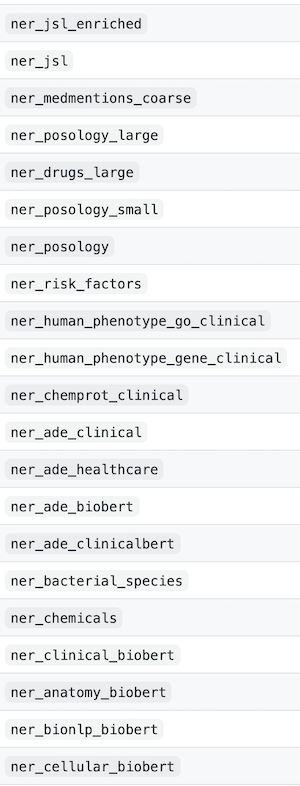

---
2. **Selecting correct embeddings for the chosen NER model**

> a. Models are trained on specific embeddings and same embeddings should be used at inference to get best results

> b. If the name of the model contains "**biobert**" (e.g: *ner_anatomy_biobert*) then the model is trained using "**biobert_pubmed_base_cased**" embeddings. Otherwise, "**embeddings_clinical**" was used to train that model.


> c. Using correct embeddings

>> To use *embeddings_clinical* :

>>> word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

>> To use *Bert* Embeddings:

>>> embeddings = BertEmbeddings.pretrained('biobert_pubmed_base_cased')\
    .setInputCols(["document", 'token'])\
    .setOutputCol("word_embeddings")

    
> d. You can find list of all embeddings at https://nlp.johnsnowlabs.com/models?tag=embeddings


### Create the pipeline

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol('text')\
    .setOutputCol('document')

sentence_detector = SentenceDetector() \
    .setInputCols(['document'])\
    .setOutputCol('sentence')

tokenizer = Tokenizer()\
    .setInputCols(['sentence']) \
    .setOutputCol('token')

word_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token']) \
    .setOutputCol('embeddings')

# change the model according to requirement
clinical_ner = NerDLModel.pretrained('ner_anatomy', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_converter = NerConverter()\
    .setInputCols(['sentence', 'token', 'ner']) \
    .setOutputCol('ner_chunk')

nlp_pipeline = Pipeline(stages=[
    document_assembler, 
    sentence_detector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter])

empty_df = spark.createDataFrame([['']]).toDF('text')
pipeline_model = nlp_pipeline.fit(empty_df)
light_pipeline = LightPipeline(pipeline_model)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_anatomy download started this may take some time.
Approximate size to download 14 MB
[OK!]


## 3. Create example inputs

In [ ]:
# Enter examples as strings in this array
input_list = [
    """This is an 11-year-old female who comes in for two different things. 1. She was seen by the allergist. No allergies present, so she stopped her Allegra, but she is still real congested and does a lot of snorting. They do not notice a lot of snoring at night though, but she seems to be always like that. 2. On her right great toe, she has got some redness and erythema. Her skin is kind of peeling a little bit, but it has been like that for about a week and a half now.
General: Well-developed female, in no acute distress, afebrile.
HEENT: Sclerae and conjunctivae clear. Extraocular muscles intact. TMs clear. Nares patent. A little bit of swelling of the turbinates on the left. Oropharynx is essentially clear. Mucous membranes are moist.
Neck: No lymphadenopathy.
Chest: Clear.
Abdomen: Positive bowel sounds and soft.
Dermatologic: She has got redness along the lateral portion of her right great toe, but no bleeding or oozing. Some dryness of her skin. Her toenails themselves are very short and even on her left foot and her left great toe the toenails are very short."""
]

## 4. Use the pipeline to create outputs

In [ ]:
df = spark.createDataFrame(pd.DataFrame({"text": input_list}))
result = pipeline_model.transform(df)

## 5. Visualize results

Visualize outputs as data frame

In [ ]:
exploded = F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata'))
select_expression_0 = F.expr("cols['0']").alias("chunk")
select_expression_1 = F.expr("cols['1']['entity']").alias("ner_label")
result.select(exploded.alias("cols")) \
    .select(select_expression_0, select_expression_1).show(truncate=False)
result = result.toPandas()

+-------------------+----------------------+
|chunk              |ner_label             |
+-------------------+----------------------+
|skin               |Organ                 |
|Extraocular muscles|Organ                 |
|turbinates         |Multi-tissue_structure|
|Mucous membranes   |Tissue                |
|Neck               |Organism_subdivision  |
|bowel              |Organ                 |
|skin               |Organ                 |
+-------------------+----------------------+



Functions to display outputs as HTML

In [ ]:
from IPython.display import HTML, display
import random

def get_color():
    r = lambda: random.randint(128,255)
    return "#%02x%02x%02x" % (r(), r(), r())

def annotation_to_html(full_annotation):
    ner_chunks = full_annotation[0]['ner_chunk']
    text = full_annotation[0]['document'][0].result
    label_color = {}
    for chunk in ner_chunks:
        label_color[chunk.metadata['entity']] = get_color()

    html_output = "<div>"
    pos = 0

    for n in ner_chunks:
        if pos < n.begin and pos < len(text):
            html_output += f"<span class=\"others\">{text[pos:n.begin]}</span>"
        pos = n.end + 1
        html_output += f"<span class=\"entity-wrapper\" style=\"color: black; background-color: {label_color[n.metadata['entity']]}\"> <span class=\"entity-name\">{n.result}</span> <span class=\"entity-type\">[{n.metadata['entity']}]</span></span>"

    if pos < len(text):
        html_output += f"<span class=\"others\">{text[pos:]}</span>"

    html_output += "</div>"
    display(HTML(html_output))

Display example outputs as HTML

In [ ]:
for example in input_list:
    annotation_to_html(light_pipeline.fullAnnotate(example))